### Thoughts from lit review
Paper 1 (Analyses of the data were conducted using grouping either by region or by population density):
- past studies show race and income / poverty are correlated - think about using therse as interaction terms?
- calculated mortality rates and use this as outcome (similar to paper) 
- possibly remove areas with low population density (as done in paper
- potentially do analysis on grouping by zipcode or population density (as done in paper)
- paper included monthly averages, where we use yearly based on zipcode - should we change this?
- paper used stepwise regression (refitting model, removing predictors at pvalue threshold of 0.03)
- do we have info on the availability of primary care within the zipcode level?

Paper 2: (57 factors)
- survival analysis: not really what I will do, but good to look at methods:
    - cox regression - risk of mortality
    - lasso regression with cross validation

Paper 3 (What weather variables are important in predicting heat-related mortality? A new application of statistical learning methods):
- Includes ICD9-codes (counts for specific diseases present that could affect mortality count)
    

### To do:
- simple logistic regression with single predictor (exposure)
- figuring out if need dummy variables for state code, other categorical variables
- bootstrapping
- cross validation
- calculate and plot confidence intervals
- calculate and plot residuals
- dimensionality reduction (pca?) potentially
- utilizing penalty terms (lasso and ridge)
- read literature to look at handled features in plotting
- read literature for other models used

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# map statecodes to integers
def map_statecode(df_sub):
    states = list(np.unique(df_sub.statecode, return_counts=True)[0])
    state_num = list(range(len(states)))
    state_dict = {}

    for i in range(len(states)):
        state_dict[states[i]] = state_num[i]

    def map_state_num(state):
        val = state_dict[state]
        return val

    df_sub['statecode'] = df_sub['statecode'].apply(map_state_num)
    return df_sub

def standardize(non_binary_predictors, X_train, X_test=None):
    
    scaler = StandardScaler().fit(X_train[non_binary_predictors])
    
    # if x_test is passed in, or just x_train 
    if X_test is not None:
        X_train[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
        X_test[non_binary_predictors] = scaler.transform(X_test[non_binary_predictors])
        return X_train, X_test
    else:
        X_train[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
        return X_train  

def split_and_standardize(df, x_cols, y_col, non_binary_preds, interact_cols=None):
    # separate into X and y
    X = df[x_cols]
    y = df[y_col]
    
    if interact_cols != None:
        for i,c in enumerate(interact_cols.keys()):
            X[c] = X[interact_cols[c][0]]*X[interact_cols[c][1]]
    
    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=109)
    
    # standardize
    X_train_standardized, X_test_standardized = standardize(non_binary_preds, X_train,X_test)
    
    return X_train_standardized, y_train, X_test_standardized, y_test

**Simple Logistic Regression Model**

In [4]:
def simple_log_reg(X_train, y_train, X_test, y_test):
    
    clf = LogisticRegression().fit(X_train, y_train)

    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    train_pred = clf.predict_proba(X_train)
    test_pred = clf.predict_proba(X_test)
    
    return train_score,test_score,train_pred,test_pred

def plot_log_preds(df, X_train, X_test, train_preds, test_preds, x_col, y_col):
    plt.scatter(df[x_cols], df[y_col], label='True Vals')
    plt.scatter(X_train[x_cols], train_preds[:,1], label='Train Pred')
    plt.scatter(X_test[x_cols], test_preds[:,1], label='Test Pred')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title("Simple Logistic Regression Predictions")
    plt.legend()
    plt.show()

**Linear Regression**

In [5]:
def lin_reg(X_train, X_test, y_train, y_test):
        
    linreg_model = LinearRegression().fit(X_train, y_train)
    
    
    train_pred = linreg_model.predict(X_train)
    test_pred = linreg_model.predict(X_test)
    
    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    
    return train_pred, test_pred, r2_train, r2_test

def lasso_reg(X_train, X_test, y_train, y_test):
    
    lasso_reg = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
    non_important_coefs = X_train.columns[lasso_reg.coef_ == 0]
#     print("Lasso Coefficients = 0:", non_important_coefs)

    train_pred = lasso_reg.predict(X_train)
    test_pred = lasso_reg.predict(X_test)
    
    r2_train = lasso_reg.score(X_train, y_train)
    r2_test = lasso_reg.score(X_test, y_test)
    
    return train_pred, test_pred, r2_train, r2_test, non_important_coefs

def plot_regression(X_train, y_train, X_test, y_test, train_preds, test_preds, x_lab, ylab, title):
    plt.scatter(X_train,y_train, label = 'train vals')
    plt.scatter(X_test,y_test, label = 'test vals')
    plt.scatter(X_train, train_preds, label='train preds')
    plt.scatter(X_test, test_preds, label='test preds')
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.title(title)
    plt.legend()
    plt.show()

In [6]:
def plot_residuals(X_test,y_test,test_pred):
    res = y_test - test_pred

    for c in X_test.columns:
        plt.scatter(X_test[c], res)
        plt.hlines(y=0,xmin=min(X_test[c]), 
                   xmax=max(X_test[c]),linestyles='dashed', label='y=0')
        plt.xlabel(c)
        plt.ylabel("test residuals")
        plt.legend()
        plt.show()


### Modeling on Data set aggregated by  zip, and year

In [7]:
df_train = pd.read_csv('zip_train_v2.csv')
df_test= pd.read_csv('zip_test_v2.csv')

**Simple linear regression**

In [8]:
x_col1 = ['pm25_summer_4y_avg', 'pm25_winter_4y_avg',
'pm25_fall_4y_avg', 'pm25_spring_4y_avg', 'ozone_summer_4y_avg',
'ozone_winter_4y_avg', 'ozone_fall_4y_avg', 'ozone_spring_4y_avg',
'no2_summer_4y_avg', 'no2_winter_4y_avg', 'no2_fall_4y_avg',
'no2_spring_4y_avg', 'summer_tmmx_4y_avg', 'summer_rmax_4y_avg',
'winter_tmmx_4y_avg', 'winter_rmax_4y_avg']

y_col1 = 'death'
non_binary_preds = x_col1

# split into train and test and standardize
X_train_standardized1, y_train1, X_test_standardized1, y_test1 = split_and_standardize(df_train, x_col1, y_col1, non_binary_preds)

# model
train_pred1, test_pred1, r2_train1, r2_test1 = lin_reg(X_train_standardized1, X_test_standardized1, y_train1, y_test1)
print(r2_train1, r2_test1)

0.1364896852256543 0.13898983908207874


**Observation**: Environmental predictors alone are not great at predicting mortality count

Looking at only CVD count as a predictor for the year of 2011 only.

In [16]:
# subset to 2011
df_train_2011 = df_train[df_train['AYEAR'] == 2011]

x_col = ['CVD_pdx2dx_25']
y_col = 'death'
non_binary_preds = x_col

# split into train and test and standardize
X_train_standardized_2011, y_train_2011, X_test_standardized_2011, y_test_2011 = split_and_standardize(df_train_2011, x_col, y_col, non_binary_preds)

# model
train_pred, test_pred, r2_train, r2_test = lin_reg(X_train_standardized_2011, X_test_standardized_2011, y_train_2011, y_test_2011)
print(r2_train, r2_test)

0.7721155199779522 0.785524270484955


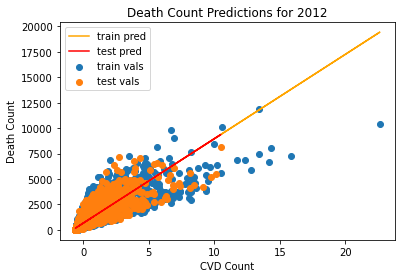

In [10]:
plt.scatter(X_train_standardized_2011, y_train_2011, label='train vals')
plt.plot(X_train_standardized_2011, train_pred, label='train pred', color='orange')
plt.scatter(X_test_standardized_2011, y_test_2011, label='test vals')
plt.plot(X_test_standardized_2011, test_pred, label='test pred', color='red')
plt.title('Death Count Predictions for 2012')
plt.xlabel('CVD Count')
plt.ylabel('Death Count')
plt.legend()
plt.show()

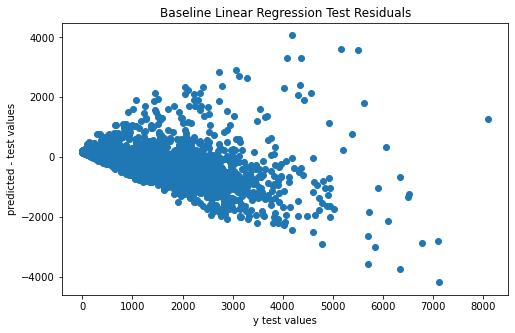

In [11]:
f,ax = plt.subplots(1, figsize=(8,5))
ax.scatter(y_test_2011, test_pred - y_test_2011)
ax.set_title('Baseline Linear Regression Test Residuals')
ax.set_xlabel('y test values')
ax.set_ylabel('predicted - test values')
# f.savefig('model1_residuals.png')
plt.show()

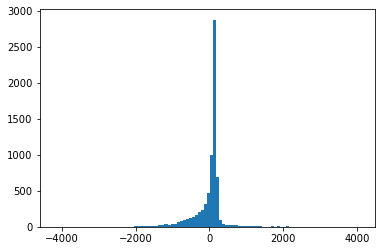

In [12]:
plt.hist(test_pred - y_test_2011, bins=100)
plt.show()
# residuals do not follow normality assummption, which means we cannot draw valid conclusion
## based on statistical inference

In [33]:
def plot_pred(X_train_standardized_2011, y_train_2011, X_test_standardized_2011, y_test_2011, train_pred,test_pred):
    plt.scatter(X_train_standardized_2011, y_train_2011, label='train vals')
    plt.scatter(X_train_standardized_2011, train_pred, label='train pred', color='orange')
    plt.scatter(X_test_standardized_2011, y_test_2011, label='test vals')
    plt.scatter(X_test_standardized_2011, test_pred, label='test pred', color='red')
    plt.title('Death Count Predictions for 2012')
    plt.xlabel('CVD Count')
    plt.ylabel('Death Count')
    plt.legend()
    plt.show()

Looking at the effect of varying polynomial terms.

Degree: 1


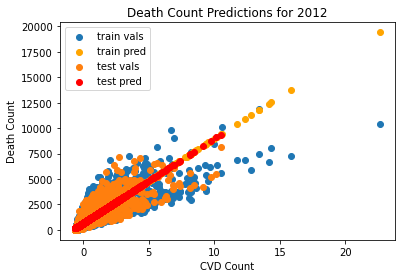

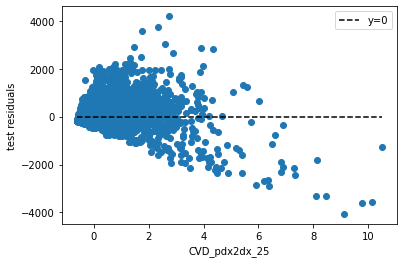

Degree: 2


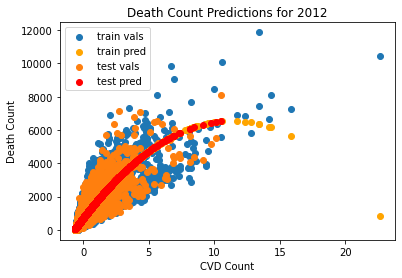

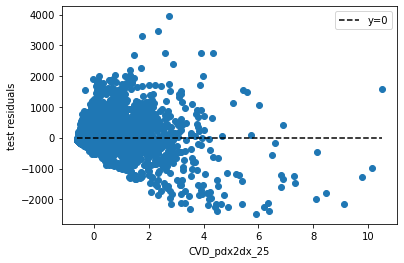

Degree: 3


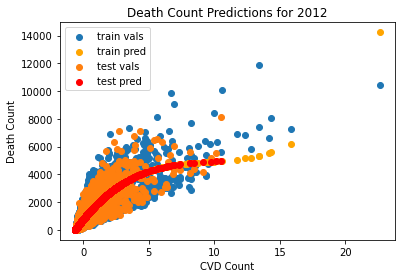

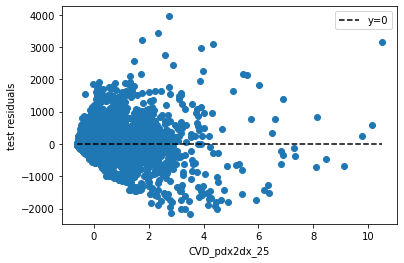

Degree: 4


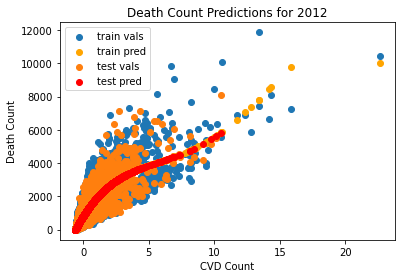

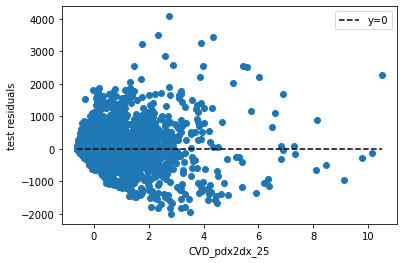

Degree: 5


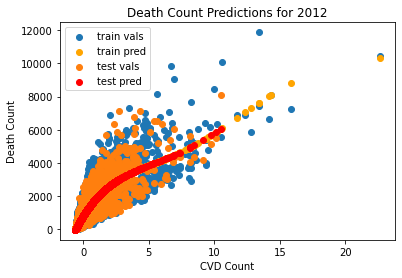

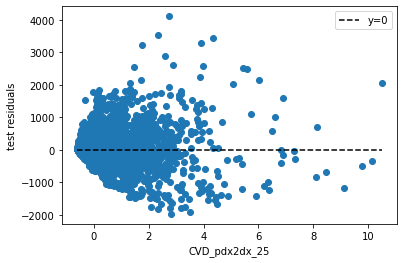

Degree: 6


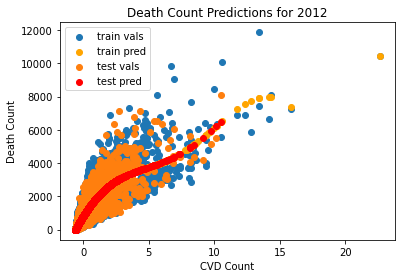

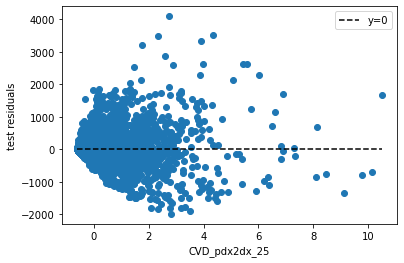

Degree: 10


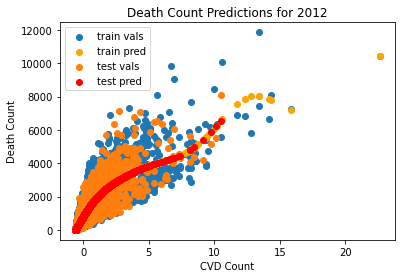

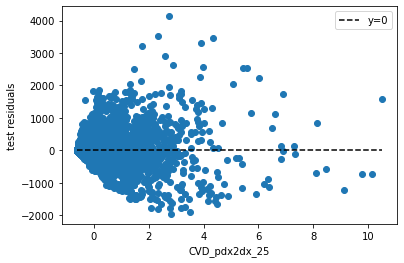

Degree: 15


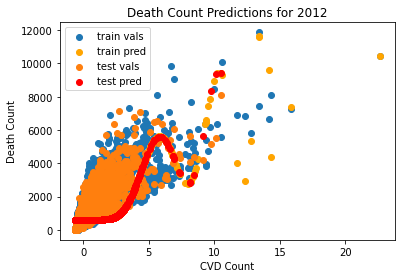

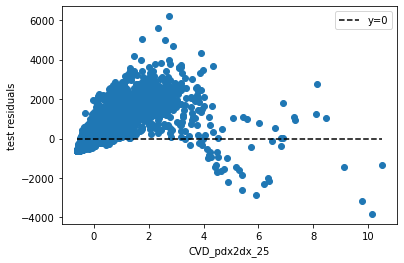

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

degrees = [1,2,3,4,5,6,10,15]
for d in degrees:
    
    model = make_pipeline(PolynomialFeatures(d), LinearRegression())
    model.fit(X_train_standardized_2011, y_train_2011)
    
    train_pred, test_pred = model.predict(X_train_standardized_2011), model.predict(X_test_standardized_2011)
    
    print('Degree:', d)
    plot_pred(X_train_standardized_2011, y_train_2011, X_test_standardized_2011, y_test_2011, train_pred,test_pred)
    plot_residuals(X_test_standardized_2011,y_test_2011,test_pred)

In [58]:
num_b = 50
bootstrapped_test_pred = np.zeros((X_test_standardized_2011.shape[0],num_b))

for i in range(num_b):
    X_train_sub = X_train_standardized_2011.sample(frac=1)
              
    model = make_pipeline(PolynomialFeatures(10), LinearRegression())
    model.fit(X_train_standardized_2011, y_train_2011)
    
    test_pred = model.predict(X_test_standardized_2011)

    bootstrapped_test_pred[:,i] = test_pred

#     plot_pred(X_train_standardized_2011, y_train_2011, X_test_standardized_2011, y_test_2011, train_pred,test_pred)
#     plot_residuals(X_test_standardized_2011,y_test_2011,test_pred)    
    

In [59]:
agg_test_pred = bootstrapped_test_pred.mean(axis=1)

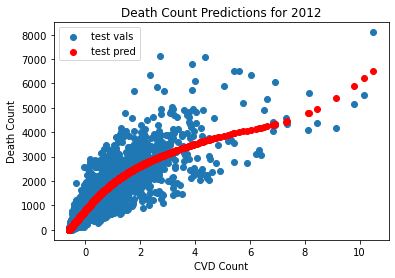

In [60]:
plt.scatter(X_test_standardized_2011, y_test_2011, label='test vals')
plt.scatter(X_test_standardized_2011, agg_test_pred, label='test pred', color='red')
plt.title('Death Count Predictions for 2012')
plt.xlabel('CVD Count')
plt.ylabel('Death Count')
plt.legend()
plt.show()

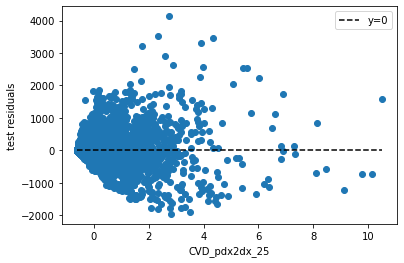

In [61]:
plot_residuals(X_test_standardized_2011,y_test_2011,agg_test_pred)

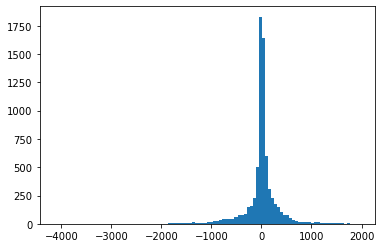

In [62]:
plt.hist(agg_test_pred - y_test_2011, bins=100)
plt.show()

**Observation**: we see that polynomial terms does in fact improve prediction and reduces residual errors.

Now, Baseline model with all years, experimenting with different predictors.

In [39]:
x_col = ['ICU_DAY','CVD_pdx2dx_25']
y_col = 'death'
non_binary_preds = ['ICU_DAY', 'CVD_pdx2dx_25']

# split into train and test and standardize
X_train_standardized, y_train, X_test_standardized, y_test = split_and_standardize(df_train, x_col, y_col, non_binary_preds)

# model
train_pred, test_pred, r2_train, r2_test = lin_reg(X_train_standardized, X_test_standardized, y_train, y_test)
print(r2_train, r2_test)

0.7713656619587044 0.7736277349929694


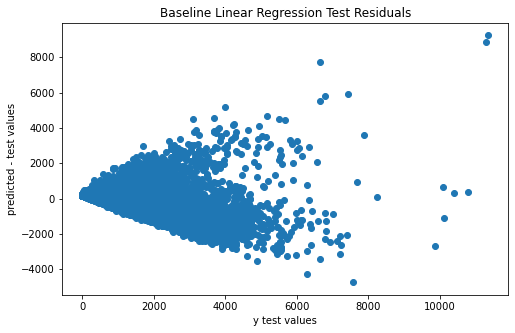

In [40]:
f,ax = plt.subplots(1, figsize=(8,5))
ax.scatter(y_test, test_pred - y_test)
ax.set_title('Baseline Linear Regression Test Residuals')
ax.set_xlabel('y test values')
ax.set_ylabel('predicted - test values')
f.savefig('model1_residuals.png')
plt.show()

In [41]:
#Compute the MSE of the model
print("MSE of train data",mean_squared_error(y_train, train_pred))
print("MSE of test data",mean_squared_error(y_test, test_pred))

MSE of train data 218393.5466514129
MSE of test data 209482.03044421278


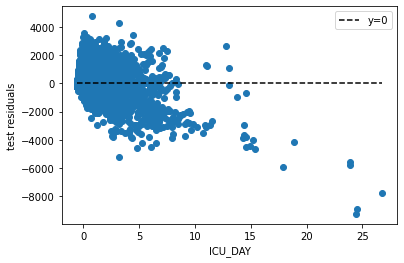

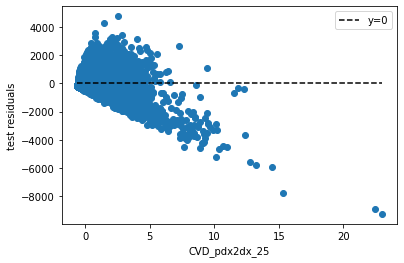

In [42]:
plot_residuals(X_test_standardized, y_test, test_pred)

Modeling association between CVD and ICU Days - implies collinearity

In [14]:
linreg_model_interact = LinearRegression().fit(X_train_standardized['ICU_DAY'].values.reshape(-1,1),X_train_standardized['CVD_pdx2dx_25'].values.reshape(-1,1))

interact_train_pred = linreg_model_interact.predict(X_train_standardized['ICU_DAY'].values.reshape(-1,1))
interact_test_pred = linreg_model_interact.predict(X_test_standardized['ICU_DAY'].values.reshape(-1,1))

r2_interact_train = r2_score(X_train_standardized['CVD_pdx2dx_25'], interact_train_pred)
r2_interact_test = r2_score(X_test_standardized['CVD_pdx2dx_25'], interact_test_pred)
print(r2_interact_train, r2_interact_test)

0.7385831645293646 0.7445977468439584


In [15]:
# add interaction term
interact_cols={'ICU_DAY*CVD_pdx2dx_25':['ICU_DAY', 'CVD_pdx2dx_25']}

# zip_df_2011 = zip_df[zip_df.AYEAR == 2011]

x_col = ['ICU_DAY','CVD_pdx2dx_25']
y_col = 'death'
non_binary_preds = ['ICU_DAY', 'CVD_pdx2dx_25', 'ICU_DAY*CVD_pdx2dx_25']

# split into train and test and standardize
X_train_standardized_interact, y_train_interact, X_test_standardized_interact, y_test_interact = split_and_standardize(df_train, x_col, y_col, non_binary_preds, interact_cols)

# model
train_pred2, test_pred2, r2_train2, r2_test2 = lin_reg(X_train_standardized_interact, X_test_standardized_interact, y_train_interact, y_test_interact)
print(r2_train2, r2_test2)

0.809897546574473 0.8127288708089435


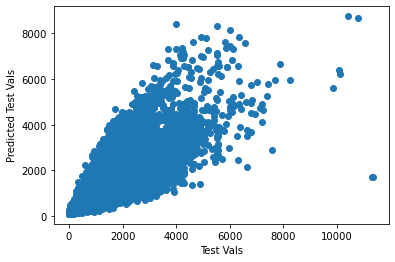

In [16]:
plt.show()
plt.scatter(y_test_interact, test_pred2)
plt.xlabel("Test Vals")
plt.ylabel("Predicted Test Vals")
plt.show()

**Multiple Linear Regression - all years and all variables**

In [41]:
x_col = ['sex', 'age','poverty', 'popdensity', 'medianhousevalue', 
        'medhouseholdincome', 'pct_owner_occ','education',
        'smoke_rate', 'mean_bmi', 'rmax', 'pr', 'race_0', 'race_1', 'race_2',
        'race_3', 'race_4', 'race_5', 'race_6','ICU_DAY', 'CCI_DAY', 'LOS', 
        'Parkinson_pdx2dx_25','Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25', 'CHF_pdx2dx_25',
       'AMI_pdx2dx_25', 'COPD_pdx2dx_25', 'DM_pdx2dx_25', 'Stroke_pdx2dx_25',
       'CVD_pdx2dx_25', 'Ischemic_stroke_pdx2dx_25','Hemo_Stroke_pdx2dx_25',
        'neo_140_149', 'neo_150_159', 'neo_160_165',
       'neo_170_176', 'neo_179_189', 'neo_190_199', 'neo_200_209',
       'neo_210_229', 'neo_230_234', 'neo_235_238', 'neo_239'] + x_col1

y_col = 'death'
non_binary_preds = x_col

# split into train and test and standardize
X_train_standardized_full, y_train_full, X_test_standardized_full, y_test_full = split_and_standardize(df_train, x_col, y_col, non_binary_preds)

# model
lin_train_pred, lin_test_pred, lin_r2_train, lin_r2_test = lin_reg(X_train_standardized_full, X_test_standardized_full, y_train_full, y_test_full)
lasso_train_pred, lasso_test_pred, lasso_r2_train, lasso_r2_test, lasso_coef = lasso_reg(X_train_standardized_full, X_test_standardized_full, y_train_full, y_test_full)

print("Linear Regression train pred:", lin_r2_train, ", test pred:", lin_r2_test)
print("Lasso Regression train pred:",lasso_r2_train, ", test pred:",lasso_r2_test)

Linear Regression train pred: 0.8212687943991039 , test pred: 0.8249050752108904
Lasso Regression train pred: 0.8208127215231996 , test pred: 0.8249566651049016


In [42]:
#Compute the MSE of the model
print("MSE of train data:",mean_squared_error(y_train_full,lin_train_pred))
print("MSE of test data:",mean_squared_error(y_test_full, lin_test_pred))

MSE of train data: 170725.63212885518
MSE of test data: 162030.62846131003


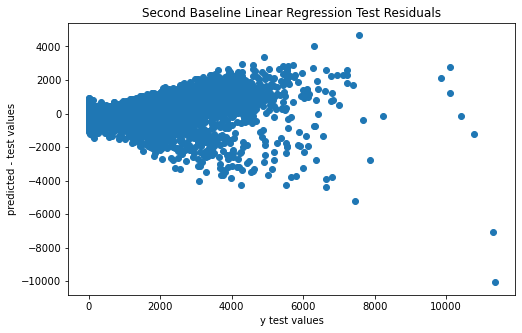

In [43]:
f,ax = plt.subplots(1, figsize=(8,5))
ax.scatter(y_test_full, (y_test_full - lin_test_pred).values)
ax.set_title('Second Baseline Linear Regression Test Residuals')
ax.set_xlabel('y test values')
ax.set_ylabel('predicted - test values')
f.savefig('model2_residuals.png')


**Look closer at Interaction terms for collinearity**

In [40]:
# find relationship between ICU_DAY and CVD_pdx2dx_25
def simple_log_reg(X_train_standardized, X_test_standardized, y_train, y_test):
    linreg_model_interact = LinearRegression().fit(X_train_standardized.values.reshape(-1,1),y_train.values.reshape(-1,1))

    interact_train_pred = linreg_model_interact.predict(X_train_standardized.values.reshape(-1,1))
    interact_test_pred = linreg_model_interact.predict(X_test_standardized.values.reshape(-1,1))

    r2_interact_train = r2_score(X_train_standardized, interact_train_pred)
    r2_interact_test = r2_score(X_test_standardized, interact_test_pred)
    print(r2_interact_train, r2_interact_test)

# run code
x_cols = ['poverty', 'poverty','medianhousevalue', 'poverty', 'poverty', 'education', 'education',
         'CVD_pdx2dx_25', 'race_0', "ICU_DAY", "Alzheimer_pdx2dx_25", 'CVD_pdx2dx_25', 'Stroke_pdx2dx_25',
         'Stroke_pdx2dx_25', 'Ischemic_stroke_pdx2dx_25', 'Alzheimer_pdx2dx_25', 'summer_tmmx_4y_avg',
         'summer_rmax_4y_avg', 'pm25_winter_4y_avg']
y_cols = ['popdensity', 'medianhousevalue', 'medhouseholdincome', 'medhouseholdincome', 'education', 
          'race_0', 'race_1','CHF_pdx2dx_25', 'race_1', 'CCI_DAY', "Dementia_pdx2dx_25", 'COPD_pdx2dx_25',
         'Ischemic_stroke_pdx2dx_25', 'Hemo_Stroke_pdx2dx_25', 'Hemo_Stroke_pdx2dx_25', 'Dementia_pdx2dx_25',
         'winter_tmmx_4y_avg', 'winter_rmax_4y_avg', 'pm25_summer_4y_avg']

for i in range(len(x_cols)):
    x = x_cols[i]
    y = y_cols[i]
    print(x,"and",y,":")
    simple_log_reg(X_train_standardized_full[x], X_test_standardized_full[x], X_train_standardized_full[y], X_test_standardized_full[y])
    print('\n')

poverty and popdensity :
0.23192700033491875 0.2319251114136155


poverty and medianhousevalue :
-0.3627746431255856 -0.3627779945961569


medianhousevalue and medhouseholdincome :
0.8936399967571883 0.89362965240703


poverty and medhouseholdincome :
-0.8360151634424751 -0.8360196787530725


poverty and education :
0.6424013753047124 0.6424004958627056


education and race_0 :
-0.4150724419985099 -0.4151082225222962


education and race_1 :
-0.6358876197115191 -0.6359289836121593


CVD_pdx2dx_25 and CHF_pdx2dx_25 :
0.9996623798439656 0.9996623601829712


race_0 and race_1 :
-0.062433052777748355 -0.0624648800875669


ICU_DAY and CCI_DAY :
0.7614553910831137 0.7614526483910197


Alzheimer_pdx2dx_25 and Dementia_pdx2dx_25 :
0.9533007278320436 0.9533006861416075


CVD_pdx2dx_25 and COPD_pdx2dx_25 :
0.9985070206857778 0.9985069337435224


Stroke_pdx2dx_25 and Ischemic_stroke_pdx2dx_25 :
0.9998254550762291 0.9998254447275745


Stroke_pdx2dx_25 and Hemo_Stroke_pdx2dx_25 :
0.9578058300730705

**Observation:** We can see some variables are highly correlated

**Lasso Regression with all interaction terms**


In [23]:
x_col = ['sex', 'age','poverty', 'popdensity', 'medianhousevalue', 
        'medhouseholdincome', 'pct_owner_occ','education',
        'smoke_rate', 'mean_bmi', 'rmax', 'pr', 'race_0', 'race_1', 'race_2',
        'race_3', 'race_4', 'race_5', 'race_6','ICU_DAY', 'CCI_DAY', 'LOS', 
        'Parkinson_pdx2dx_25','Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25', 'CHF_pdx2dx_25',
       'AMI_pdx2dx_25', 'COPD_pdx2dx_25', 'DM_pdx2dx_25', 'Stroke_pdx2dx_25',
       'CVD_pdx2dx_25', 'Ischemic_stroke_pdx2dx_25','Hemo_Stroke_pdx2dx_25',
        'neo_140_149', 'neo_150_159', 'neo_160_165',
       'neo_170_176', 'neo_179_189', 'neo_190_199', 'neo_200_209',
       'neo_210_229', 'neo_230_234', 'neo_235_238', 'neo_239'] + x_col1 

poly = PolynomialFeatures(interaction_only=True)
X_poly = poly.fit_transform(df_train[x_col])

poly_names = poly.get_feature_names(df_train[x_col].columns) 
X_poly_df = pd.DataFrame(X_poly, columns = poly_names)
X_poly_df['death'] = df_train['death']

y_col = 'death'
non_binary_preds = poly_names[1:] 

# split into train and test and standardize
X_train_standardized_full3, y_train_full3, X_test_standardized_full3, y_test_full3 = split_and_standardize(X_poly_df.iloc[:,1:], poly_names[1:], y_col, non_binary_preds)

# model
lasso_train_pred3, lasso_test_pred3, lasso_r2_train3, lasso_r2_test3, non_important_coefs = lasso_reg(X_train_standardized_full3, X_test_standardized_full3, y_train_full3, y_test_full3)

print("Lasso Regression train pred:",lasso_r2_train3,", test pred:", lasso_r2_test3)

Lasso Regression train pred: 0.9019518516266212 , test pred: 0.8996732968521721


In [24]:
#Compute the MSE of the model
print("MSE of train data:",mean_squared_error(y_train,lasso_train_pred3))
print("MSE of test data:",mean_squared_error(y_test, lasso_test_pred3))

print(len(non_binary_preds) - len(non_important_coefs))
important_pred = list(set(non_binary_preds) - set(non_important_coefs))

MSE of train data: 93656.46057067144
MSE of test data: 92841.06196723376
355


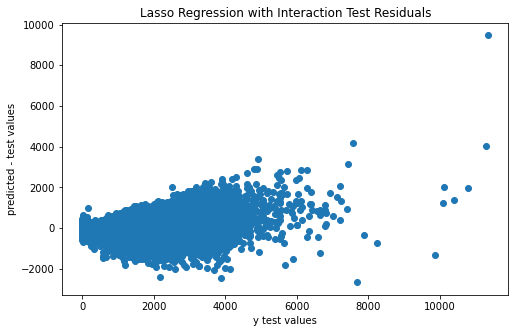

In [44]:
f,ax = plt.subplots(1, figsize=(8,5))
ax.scatter(y_test_full3, y_test_full3 - lasso_test_pred3)
ax.set_title('Lasso Regression with Interaction Test Residuals')
ax.set_xlabel('y test values')
ax.set_ylabel('predicted - test values')
f.savefig('model3_residuals.png')


Add Polynomial terms

In [27]:
# poverty, popdensity, medianhousevalue,medhouseholdincome, education, race_0,race_2,race_3, race_4, race_5,
# race_6, CCI_DAY, CVD_pdx_25
x_col = ['sex', 'age','poverty', 'popdensity', 'medianhousevalue', 
        'medhouseholdincome', 'pct_owner_occ','education',
        'smoke_rate', 'mean_bmi', 'rmax', 'pr', 'race_0', 'race_1', 'race_2',
        'race_3', 'race_4', 'race_5', 'race_6','ICU_DAY', 'CCI_DAY', 'LOS', 
        'Parkinson_pdx2dx_25','Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25', 'CHF_pdx2dx_25',
       'AMI_pdx2dx_25', 'COPD_pdx2dx_25', 'DM_pdx2dx_25', 'Stroke_pdx2dx_25',
       'CVD_pdx2dx_25', 'Ischemic_stroke_pdx2dx_25','Hemo_Stroke_pdx2dx_25',
        'neo_140_149', 'neo_150_159', 'neo_160_165',
       'neo_170_176', 'neo_179_189', 'neo_190_199', 'neo_200_209',
       'neo_210_229', 'neo_230_234', 'neo_235_238', 'neo_239']+ x_col1

poly2 = PolynomialFeatures() #interaction_only=True
X_poly2 = poly2.fit_transform(df_train[x_col])

poly_names2 = poly2.get_feature_names(df_train[x_col].columns) 
X_poly_df2 = pd.DataFrame(X_poly2, columns = poly_names2)
X_poly_df2['death'] = df_train['death']

y_col = 'death'
non_binary_preds = poly_names2[1:] 

# split into train and test and standardize
X_train_standardized_full4, y_train_full4, X_test_standardized_full4, y_test_full4 = split_and_standardize(X_poly_df2.iloc[:,1:], poly_names2[1:], y_col, non_binary_preds)

# model
lasso_train_pred4, lasso_test_pred4, lasso_r2_train4, lasso_r2_test4, non_important_coefs2 = lasso_reg(X_train_standardized_full4, X_test_standardized_full4, y_train_full4, y_test_full4)

print("Lasso Regression train pred:",lasso_r2_train4,", test pred:", lasso_r2_test4)

Lasso Regression train pred: 0.903759000936068 , test pred: 0.901920597053972


In [28]:
#Compute the MSE of the model
print("MSE of train data:",mean_squared_error(y_train_full4,lasso_train_pred4))
print("MSE of test data:",mean_squared_error(y_test_full4, lasso_test_pred4))

print(len(non_binary_preds) - len(non_important_coefs2))
important_preds2 = list(set(non_binary_preds) - set(non_important_coefs2))

MSE of train data: 91930.25552903213
MSE of test data: 90761.43878867825
369


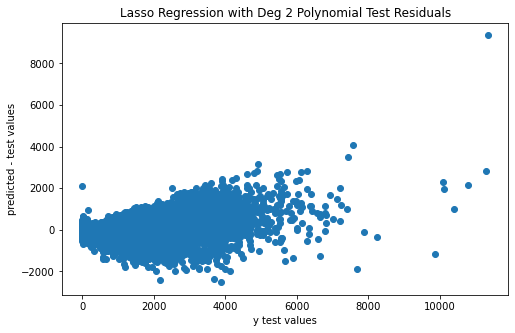

In [45]:
f,ax = plt.subplots(1, figsize=(8,5))
ax.scatter(y_test_full4, y_test_full4 - lasso_test_pred4)
ax.set_title('Lasso Regression with Deg 2 Polynomial Test Residuals')
ax.set_xlabel('y test values')
ax.set_ylabel('predicted - test values')
f.savefig('model4_residuals.png')


In [30]:
res4 = y_test_full4 - lasso_test_pred4
res4[res4 > 6000].index

Int64Index([11949], dtype='int64')

## Additional Thoughts
Notes about residuals

When your residuals exhibit behavior violating homoskedacity, it implies that there is a relationship / behavior not being explained or accounted for. This could be due to collinearity between predictors or could be because linear regression is not the right model for your data.

Multicollinearity undermines the statistical significance of an independent variable
- Checking for multicollinearity: https://www.theanalysisfactor.com/eight-ways-to-detect-multicollinearity/ 

How to check if it’s multicollinearity? Easiest way could be to plot the variables side by side to see potential trend

Ways to check results of linear regression: https://www.theanalysisfactor.com/steps-to-take-when-your-regression-or-other-statistical-results-just-lookwrong/ 

More on homoskedacity: 
https://statisticsbyjim.com/regression/heteroscedasticity-regression/



I think residuals showing linear model is probably unfit for data and not capturing trend like it should. data doesn’t seem to exhibit polynomial trend, so will probably try two things;
- Look at data set to make sure all looks good
- Try random forest
- try all interaction terms in the model 
- try modeling residuals to determine trend (r^2)
